In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from collections import OrderedDict
from visualisation import label_barchart

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

### Data Preparation

In [2]:
def load_data(filename):
    return pd.read_csv(filename)

target_name = "multiplier"
train = load_data("data2014.csv")
test = load_data("data2015.csv")
X_train, y_train = train.drop(target_name, axis=1), train[target_name]
X_test, y_test = test.drop(target_name, axis=1), test[target_name]

### Preprocessing

Prepare data for classification

In [3]:
kbest_scoring = f_classif
categorical_features = X_train.loc[:, train.nunique() == 2].columns
categorical_indices = [col in categorical_features for col in X_train.columns]

preprocessors = [
    ("encoder", OneHotEncoder(categorical_features=categorical_indices, sparse=False)),
    ("scaler", StandardScaler()),
#     ("anova_filter", SelectKBest(score_func=kbest_scoring, k=10)),
]
    
def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut
    
def pipe_fit(preprocessors, X_train, y_train):
    X_train = X_train.copy()
    for name, pp in preprocessors:
        X_train = pp.fit_transform(X_train, y_train)
    return preprocessors, X_train

def pipe_transform(preprocessors, X_test):
    X_test = X_test.copy()
    for name, pp in preprocessors:
        X_test = pp.transform(X_test)
    return X_test

# bins = np.linspace(-2, 2, 5)
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.linspace(0, 2, 3)

y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)

# preprocessors, X_train_transformed = pipe_fit(preprocessors, X_train, y_train_bins)
# X_test_transformed = pipe_transform(preprocessors, X_test)

/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


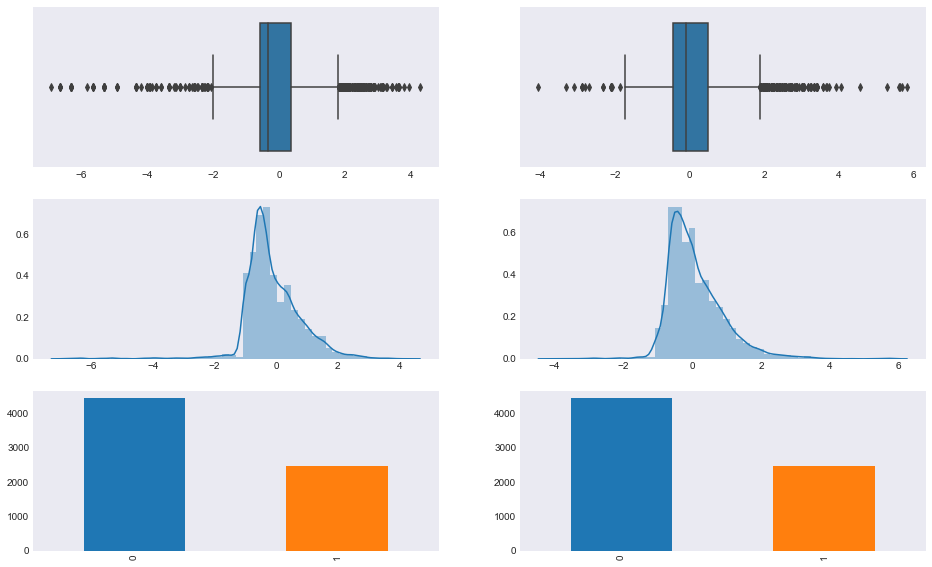

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(16,10))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_train_bins])):
    sns.boxplot(np.log2(series), ax=axs[0, i % 3])
    sns.distplot(np.log2(series), ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar(ax=axs[2, i % 3])
    [ax.set_xlabel("") for ax in axs[:, i % 3]]

### Classification

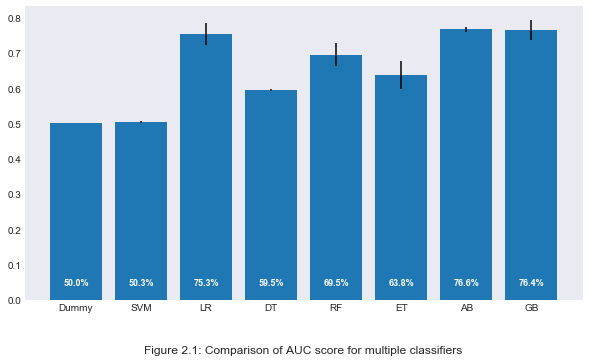

In [5]:
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    classification_report,
    precision_recall_fscore_support
)

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    

]

results = OrderedDict()
for name, model in models:
#     print(name)
    kfold = KFold(n_splits=3)
    cv_results = cross_val_score(model, X_train, y_train_bins, cv=kfold, scoring=scoring)
    results[name] = cv_results
    
results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.bar(range(results.shape[1]), results.mean(), yerr=results.std())
plt.gca().set_xticklabels([""] + list(results.columns) + [""])
plt.title("Figure 2.1: Comparison of AUC score for multiple classifiers", y=-.2)
plt.subplots_adjust(bottom=.2)
label_barchart(plt.gca())


In [ ]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier()  #max_features="auto", max_depth=None)

classifiers = [
#     ("LogisticRegression", LogisticRegression()), 
    ("AdaBoost", AdaBoostClassifier(base_estimator=LogisticRegression())),
#     ("GradientBoosting", GradientBoostingClassifier())
]

all_params = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoost": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "learning_rate": np.logspace(-3, 3, 7),
        "n_estimators": range(20, 100, 10)
    },
    
    "GradientBoosting": {

    },
}

results = pd.DataFrame(index=[item[0] for item in classifiers], 
                       columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te", 
                                "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])


best_models, scores = [], []
for i, ((name, clf)) in enumerate(classifiers):
    params = all_params[name]
    gs = GridSearchCV(clf, params, n_jobs=-1, return_train_score=True).fit(X_train, y_train_bins)
    best_models.append(gs.best_estimator_)
    y_pred = gs.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test_bins, y_pred)
    auc_score_te = roc_auc_score(y_test_bins, y_pred)
    auc_score_tr = gs.best_score_
    accuracy = (y_pred == y_test_bins).mean()
    params = gs.best_params_
    [[TP, FN], [FP, TN]] = confusion_matrix(y_test_bins, y_pred)
    results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision, 
                            recall, fscore, support, TP, FP, FN, TN)
    
    scores.append(roc_auc_score(y_test_bins, y_pred))
    gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
    print("\n{}:\n".format(name))
    print("\tAccuracy: {:.2%}".format((y_pred == y_test_bins).mean()))
    print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
    print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
    print(classification_report(y_test_bins, y_pred))
    print(best_models[-1], "\n")
    if i + 1 < len(classifiers): print("#" * 100)

    
#results


/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:166: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/quent/.local/b

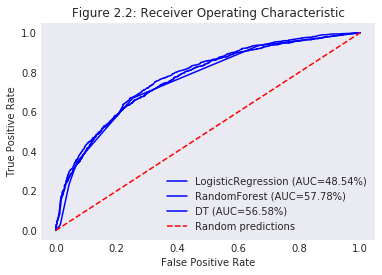

In [13]:
for name, model in zip(map(lambda x:x[0], classifiers), best_models):
    scores = model.predict_proba(X_test_transformed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), scores.ravel())
    plt.plot(fpr, tpr, 'b', label=f'{name} (AUC={scores[0]:.2%})')

plt.title('Figure 2.2: Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--', label="Random predictions")
plt.legend(loc=4)
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate');

In [14]:
clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Coefficients"] = clf.coef_[0]
coef.sort_values("Coefficients", ascending=False)

,Coefficients
Followers,1.506
StartPrice,0.892
Forced,0.717
SP.EV,0.497
LotNr,0.082
LotsCtgry,0.080
Allocate,-0.135
Evening,-0.198
Morning,-0.260
Dealer,-0.297


In [30]:
# sns.pairplot(train.loc[:, train.nunique() != 2])
# plt.savefig("pairplot.png")

In [3]:
# # Confidence Threshold
# alpha = .1

# np.random.seed(42)  # To make sure our results are reproducible
# anova_filter = SelectKBest()
# anova_filter.fit(X_train, y_train)


# anova_scores = pd.DataFrame(index=X_train.columns)
# anova_scores["Fisher"] = anova_filter.scores_
# anova_scores["p-value"] = anova_filter.pvalues_
# anova_scores = anova_scores.sort_values("Fisher", ascending=False)
# # selected_features = list(anova_scores.loc[anova_scores["p-value"] < 1 - alpha, :].index)
# # if len(selected_features) == X_train.shape[1]:
# #     print("No discarded feature")
# # X = X[selected_features]
# anova_scores.style.apply(lambda f: ["color: red"] * 2 if f["p-value"] > 1-alpha else ["color: black"]*2, axis=1)

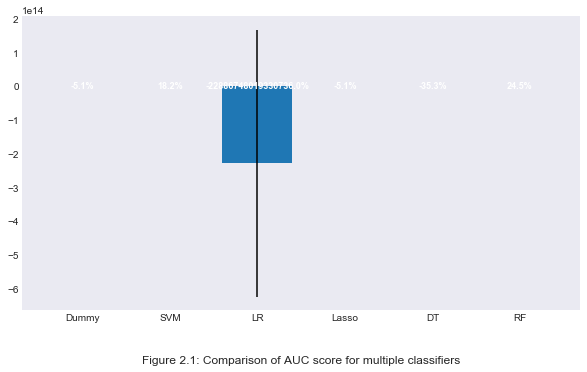

In [14]:
from sklearn.metrics import (
    r2_score, 
    explained_variance_score, 
    mean_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error,
    median_absolute_error
)

from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


scoring = "r2"

metrics = [
    r2_score, 
    explained_variance_score, 
    mean_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error,
    median_absolute_error
]

models = [
    
    ("Dummy", DummyRegressor(strategy="mean")),
    ("SVM", SVR()), 
    ("LR", LinearRegression()),
    ("Lasso", Lasso()),
#     ("LARS", LassoLars()),
    ("DT", DecisionTreeRegressor()), 
    ("RF", RandomForestRegressor())

]

results = OrderedDict()
for name, model in models:
    kfold = KFold(n_splits=3)
    cv_results = cross_val_score(model, X_train_transformed, np.log2(y_train), cv=kfold, scoring=scoring)
    results[name] = cv_results
    
results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.bar(range(results.shape[1]), results.mean(), yerr=results.std())
plt.gca().set_xticklabels([""] + list(results.columns) + [""])
plt.title("Figure 2.1: Comparison of AUC score for multiple classifiers", y=-.2)
plt.subplots_adjust(bottom=.2)
label_barchart(plt.gca())


In [ ]:
n_features = X_train.shape[1]

classifiers = [
#     ("LR", LinearRegression()),
#     ("Lasso", Lasso()),
#     ("DT", DecisionTreeRegressor()),
#     ("RF", RandomForestRegressor(n_estimators=50)),
    ("SVM", SVC())
]

all_params = {
    "LR": {"normalize": [True, False]}, 
    "Lasso": {"alpha": np.logspace(-3, 3, 7)},
    "RF": {
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "DT": {
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "SVM": {
        "C": np.logspace(-2, 2, 5),
        "epsilon": np.logspace(-2, 2, 5),
        "kernel": ["linear", "rbf", "sigmoid"],
    }
}
results = pd.DataFrame(index=[item[0] for item in classifiers], 
                       columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te", 
                                "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])


best_models, scores = [], []
for i, ((name, clf)) in enumerate(classifiers):
    params = all_params[name]
    gs = RandomizedSearchCV(clf, params, n_jobs=-1, verbose=5).fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    y_pred = gs.predict(X_test)
#     precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    r2_score_te = r2_score(y_test, y_pred)
    r2_score_tr = gs.best_score_
#     accuracy = (y_pred == y_test).mean()
    params = gs.best_params_
    print(f"{name}:\nscore: train {r2_score_tr} test {r2_score_te}\nparams:")
    pprint(params)
#     [[TP, FN], [FP, TN]] = confusion_matrix(y_test, y_pred)
#     results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision, 
#                             recall, fscore, support, TP, FP, FN, TN)
    
#     scores.append(roc_auc_score(y_test, y_pred))
#     gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
#     print("\n{}:\n".format(name))
#     print("\tAccuracy: {:.2%}".format((y_pred == y_test).mean()))
#     print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
#     print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
#     print(classification_report(y_test, y_pred))
#     print(best_models[-1], "\n")
#     if i + 1 < len(classifiers): print("#" * 100)
    
#results
